# Estimates Analysis

TBA 

Conclusions:

TBA

## Data and Methodology

Datasources:

* EPS Consensus values (Estimize consensuses.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)


In [2]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import math
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats
import statsmodels.api as sm

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimatesService, 
    EstimizeConsensusService, EventStudyService, MarketCapService, ReleasesService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
asset_info_service = injector.get(AssetInfoService)
calendar_service = injector.get(CalendarService)
estimates_service = injector.get(EstimatesService)
releases_service = injector.get(ReleasesService)
estimize_consensus_service = injector.get(EstimizeConsensusService)


In [270]:
def get_estimates(start_date, end_date):
    rdf = releases_service.get_releases(start_date, end_date)
    rdf.reset_index(inplace=True)
    rdf = rdf[rdf['estimize.eps'].notnull()]
    rdf = rdf[rdf['reported.eps'].notnull()]
    rdf.set_index('asset', inplace=True)
    
    adf = asset_info_service.get_asset_info()[['industry', 'sector']]
    rdf = rdf.join(adf, how='inner')
    rdf.reset_index(inplace=True)
    rdf.set_index('release_id', inplace=True)
    
    df = estimates_service.get_estimates()
    df.reset_index(inplace=True)
    df.set_index('release_id', inplace=True)
    df = df[df['flagged'] == False]
    
    df = df.join(rdf, how='inner')
    df.reset_index(inplace=True)
    df.set_index(['asset', 'fiscal_year', 'fiscal_quarter'], inplace=True)
    
    cdf = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    cdf.reset_index(inplace=True)
    cdf.set_index(['asset', 'fiscal_year', 'fiscal_quarter'], inplace=True)
    
    df = df.join(cdf, how='inner', rsuffix='_right')
    df.reset_index(inplace=True)
    
    df = df[['as_of_date', 'created_at', 'reports_at_date', 'bmo', 'sector', 'industry', 'asset', 'release_id', 'user_id', 'eps', 'estimize.eps.mean', 'estimize.eps.sd', 'estimize.eps.weighted', 'wallstreet.eps', 'actual.eps']].copy()
    
    return df

def get_estimate_factors(df):
    df = df.copy()
    df['error_z_score'] = (df['eps'] - df['actual.eps']) / (df['estimize.eps.sd'] + 0.01)
    df['eps_z_score'] = (df['eps'] - df['estimize.eps.mean']) / (df['estimize.eps.sd'] + 0.01)
#     df['reports_at_date'] = pd.to_datetime(df['reports_at_date'])
    df['ttr'] = df['as_of_date'].subtract(df['created_at']).dt.total_seconds() / timedelta(days=1).total_seconds()
    df = df[df['ttr'] > 0]
    df.dropna(subset=['error_z_score', 'eps_z_score'], inplace=True)
    
#     df['error_z_score'] = mstats.winsorize(df['error_z_score'], limits=[0.01, 0.01])
#     df['eps_z_score'] = mstats.winsorize(df['eps_z_score'], limits=[0.01, 0.01])
    
    return df

def get_factors(df, index):
    if index == 'user':
        column = 'user_id'
    else:
        column = index
        
    error_z_score_column = 'error_z_score_{}'.format(index)
            
    df = df.groupby([column, 'reports_at_date'])[['error_z_score']].agg(['sum', 'count'])
    df.columns = ['_'.join(x) for x in df.columns.ravel()]
    df.reset_index(inplace=True)
    df.set_index('reports_at_date', inplace=True)
    
    df = df.groupby(column)[['error_z_score_sum', 'error_z_score_count']].expanding().sum()
    df[error_z_score_column] = df['error_z_score_sum'] / df['error_z_score_count']
    df.drop(['error_z_score_sum', 'error_z_score_count'], axis=1, inplace=True)
    
    df.reset_index(inplace=True)
    df.set_index('reports_at_date', inplace=True)
    df[error_z_score_column] = df.groupby(column)[error_z_score_column].transform(lambda vals: vals.shift(1))
    df.fillna(0.0, inplace=True)
    
    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', column], inplace=True)
    
    return df


In [237]:
start_date = '2012-01-01'
end_date = '2017-10-01'

edf = get_estimates(start_date, end_date)
print(len(edf))

606830


In [271]:
efdf = get_estimate_factors(edf)
print(len(efdf))
print(efdf.dtypes)
display(efdf.head())
print(efdf['error_z_score'].min())
print(efdf['error_z_score'].mean())
print(efdf['error_z_score'].max())

470840
as_of_date               datetime64[ns]
created_at               datetime64[ns]
reports_at_date                  object
bmo                                bool
sector                           object
industry                         object
asset                            object
release_id                        int64
user_id                           int64
eps                             float64
estimize.eps.mean               float64
estimize.eps.sd                 float64
estimize.eps.weighted           float64
wallstreet.eps                  float64
actual.eps                      float64
error_z_score                   float64
eps_z_score                     float64
ttr                             float64
dtype: object


,as_of_date,created_at,reports_at_date,bmo,sector,industry,asset,release_id,user_id,eps,estimize.eps.mean,estimize.eps.sd,estimize.eps.weighted,wallstreet.eps,actual.eps,error_z_score,eps_z_score,ttr
0,2016-01-28,2015-12-15 21:05:03,2016-01-28,True,Consumer Discretionary,Internet & Catalog Retail,Equity(0 [FLWS]),126036,54714,-0.16,0.45000,0.482967,0.427836,-0.138,0.92,-2.190816,-1.237405,43.121493
1,2016-01-28,2016-01-11 14:30:29,2016-01-28,True,Consumer Discretionary,Internet & Catalog Retail,Equity(0 [FLWS]),126036,55137,0.90,0.45000,0.482967,0.427836,-0.138,0.92,-0.040571,0.912840,16.395498
2,2016-01-28,2016-01-21 11:45:22,2016-01-28,True,Consumer Discretionary,Internet & Catalog Retail,Equity(0 [FLWS]),126036,48763,0.87,0.45000,0.482967,0.427836,-0.138,0.92,-0.101427,0.851984,6.510162
3,2016-01-28,2016-01-27 02:48:01,2016-01-28,True,Consumer Discretionary,Internet & Catalog Retail,Equity(0 [FLWS]),126036,55238,0.89,0.45000,0.482967,0.427836,-0.138,0.92,-0.060856,0.892555,0.883322
8,2016-04-26,2016-01-11 14:30:29,2016-04-26,True,Consumer Discretionary,Internet & Catalog Retail,Equity(0 [FLWS]),126037,55137,-0.13,-0.15125,0.037562,-0.158300,-0.236,-0.14,0.210250,0.446781,105.395498


-3.011001751855973e+19
-63949574204739.92
2492.5239365233806


In [111]:
ufdf = get_factors(efdf, index='user')
print(len(ufdf))
display(ufdf.head())

192623


,,error_z_score_user
reports_at_date,user_id,
2014-01-14,1,0.000000
2014-01-16,1,-2.580370
2014-04-23,1,-2.905386
2014-05-08,1,-2.423380
2014-05-21,1,-2.058345


In [112]:
afdf = get_factors(efdf, index='asset')
print(len(afdf))
display(afdf.head())

23479


,,error_z_score_asset
reports_at_date,asset,
2016-01-28,Equity(0 [FLWS]),0.000000
2016-04-26,Equity(0 [FLWS]),-1.097944
2016-08-25,Equity(0 [FLWS]),-0.694674
2016-11-02,Equity(0 [FLWS]),-0.099636
2012-07-26,Equity(4 [DDD]),0.000000


In [113]:
ifdf = get_factors(efdf, index='industry')
print(len(ifdf))
display(ifdf.head())

13516


,,error_z_score_industry
reports_at_date,industry,
2012-01-09,Aerospace & Defense,0.000000
2012-01-25,Aerospace & Defense,2.634760
2012-04-10,Aerospace & Defense,1.575444
2012-07-09,Aerospace & Defense,0.397072
2012-07-18,Aerospace & Defense,0.358569


In [114]:
sfdf = get_factors(efdf, index='sector')
print(len(sfdf))
display(sfdf.head())

5700


,,error_z_score_sector
reports_at_date,sector,
2012-01-05,Consumer Discretionary,0.000000
2012-01-11,Consumer Discretionary,0.131359
2012-01-24,Consumer Discretionary,0.467736
2012-01-25,Consumer Discretionary,-0.103264
2012-01-26,Consumer Discretionary,-0.199364


## EPS Deltas

-3.011001751855973e+19
-63949574204739.92
2492.5239365233806


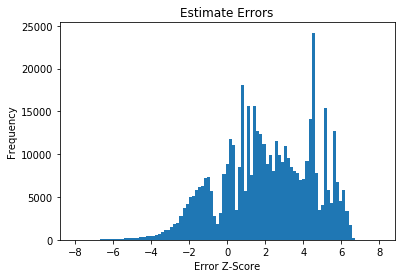

In [260]:
df = efdf.copy()
# df = afdf.copy()

df['ttr'] = np.log(df['ttr'])

# df['error_z_score'] = df['error_z_score_asset']
# df['error_z_score'] = df['error_z_score_industry']
# df['error_z_score'] = df['error_z_score_sector']

# df = df[df['error_z_score'] < 0]
# df['error_z_score'] = np.log(-1 * df['error_z_score'])

# df = df[df['error_z_score'] > 0]
# df['error_z_score'] = np.log(df['error_z_score'])

print(df.error_z_score.min())
print(df.error_z_score.mean())
print(df.error_z_score.max())

bins = np.linspace(-8, 8, 100)

plt.hist(df['ttr'], bins)
plt.title("Estimate Errors")
plt.xlabel("Error Z-Score")
plt.ylabel("Frequency")
plt.show()


In [272]:
jdf = efdf.copy()
jdf.reset_index(inplace=True)
jdf.set_index(['reports_at_date', 'sector'], inplace=True)
jdf = jdf.join(sfdf, how='inner')

jdf.reset_index(inplace=True)
jdf.set_index(['reports_at_date', 'industry'], inplace=True)
jdf = jdf.join(ifdf, how='inner')

jdf.reset_index(inplace=True)
jdf.set_index(['reports_at_date', 'asset'], inplace=True)
jdf = jdf.join(afdf, how='inner')

jdf.reset_index(inplace=True)
jdf.set_index(['reports_at_date', 'user_id'], inplace=True)
jdf = jdf.join(ufdf, how='inner')

In [346]:
df = jdf.copy()
# df = df[df['error_z_score'] < 0]
# df['error_z_score'] *= -1
# df['error_z_score'] = np.log(-1 * df['error_z_score'])

# df = df[df['error_z_score'] > 0]
# df['error_z_score'] = np.log(df['error_z_score'])

df['error_z_score'] = mstats.winsorize(df['error_z_score'], limits=[0.001, 0.001])
df['eps_z_score'] = mstats.winsorize(df['eps_z_score'], limits=[0.001, 0.001])

df['eps_z_score_2'] = df['eps_z_score'] * df['eps_z_score']
df['error_z_score_user_2'] = df['error_z_score_user'] * df['error_z_score_user']
# df['ttr'] = np.log(df['ttr'])

# model_columns = ['eps_z_score'] # R2 = 27.5%
# model_columns = ['eps_z_score_2', 'eps_z_score'] # R2 = 27.5%
# model_columns = ['error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 27.5%
# model_columns = ['error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 29.7%
# model_columns = ['error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 29.9%
# model_columns = ['ttr', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 29.9%  
model_columns = ['error_z_score_user_2', 'ttr', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 29.9%  

value_column = 'error_z_score'

X = df[model_columns]
X = sm.add_constant(X)
y = df[value_column]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
# model = sm.GLM(y, X, family=sm.families.Tweedie(var_power=1.2, link_power=0)).fit()
# r2 = 1 - (model.deviance / model.null_deviance)
# print('r2: ', r2)
df['prediction'] = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

p = model.params

# generate x-values for your regression line (two is sufficient)
x = np.arange(-6, 14)

# scatter-plot data
# ax = df.plot(x=model_columns[0], y=value_column, kind='scatter')
# bx = df.plot(x=model_columns[0], y='prediction', color='red', kind='scatter')

                            OLS Regression Results                            
Dep. Variable:          error_z_score   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                 4.204e+04
Date:                Tue, 27 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:10:12   Log-Likelihood:            -1.0692e+06
No. Observations:              470840   AIC:                         2.138e+06
Df Residuals:                  470831   BIC:                         2.139e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

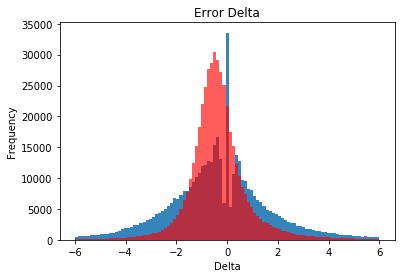

In [351]:
bins = np.linspace(-6, 6, 100)

plt.hist(df['error_z_score'], bins, alpha=0.90)
plt.hist(df['prediction'], bins, color='red', alpha=0.64)
plt.title("Error Delta")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()

In [352]:
tdf = df[['release_id', 'prediction', 'eps', 'estimize.eps.sd', 'actual.eps', 'estimize.eps.weighted']].copy()
tdf['eps_delta_t'] = tdf['prediction'] * tdf['estimize.eps.sd']
tdf['eps_t'] = tdf['eps'] - tdf['eps_delta_t']
# display(tdf)

adf = tdf.groupby('release_id')['eps', 'eps_t', 'actual.eps', 'estimize.eps.weighted'].mean()
adf['eps_error'] = np.abs(adf['actual.eps'] - adf['eps'])
adf['eps_t_error'] = np.abs(adf['actual.eps'] - adf['eps_t'])
adf['eps_w_error'] = np.abs(adf['actual.eps'] - adf['estimize.eps.weighted'])
# display(adf)

adf['am_win'] = adf['eps_error'] < adf['eps_t_error']
adf['at_win'] = adf['eps_error'] > adf['eps_t_error']

adf['bm_win'] = adf['eps_error'] < adf['eps_w_error']
adf['bw_win'] = adf['eps_error'] > adf['eps_w_error']

adf['ct_win'] = adf['eps_t_error'] < adf['eps_w_error']
adf['cw_win'] = adf['eps_t_error'] > adf['eps_w_error']

adf['dw_win'] = adf['eps_w_error'] < adf['eps_error']
adf['dm_win'] = adf['eps_w_error'] > adf['eps_error']

print(adf.mean())


eps                     -3.070084e+12
eps_t                   -3.070084e+12
actual.eps               6.513016e-01
estimize.eps.weighted    6.387517e-01
eps_error                3.070084e+12
eps_t_error              3.070084e+12
eps_w_error              8.560496e-02
am_win                   4.087510e-01
at_win                   5.835554e-01
bm_win                   4.156709e-01
bw_win                   5.778819e-01
ct_win                   5.023640e-01
cw_win                   4.913178e-01
dw_win                   5.778819e-01
dm_win                   4.156709e-01
dtype: float64


In [15]:
from scipy import stats
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

df = edf[['asset', 'user_id', 'eps', 'actual.eps', 'estimize.eps.mean', 'estimize.eps.sd']].copy()
df['error_delta'] = (df['eps'] - df['actual.eps']) / (df['estimize.eps.sd'] + 0.01)
df['eps_z_score'] = (df['eps'] - df['estimize.eps.mean']) / (df['estimize.eps.sd'] + 0.01)
df.dropna(inplace=True)

df['error_delta'] = mstats.winsorize(df['error_delta'], limits=[0.01, 0.01])
df['eps_z_score'] = mstats.winsorize(df['eps_z_score'], limits=[0.01, 0.01])
df['error_delta_p'] = (df['error_delta'] > 0) * 1.0
df['error_delta_0'] = (df['error_delta'] == 0) * 1.0
df['error_delta_n'] = (df['error_delta'] < 0) * 1.0

adf = df.groupby(['asset'])[['error_delta']].mean()
udf = df.groupby(['user_id'])[['error_delta']].mean()

df.set_index('asset', inplace=True)
df = df.join(adf, how='inner', lsuffix='_asset')
df.reset_index(inplace=True)

df.set_index('user_id', inplace=True)
df = df.join(udf, how='inner', lsuffix='_user')
df.reset_index(inplace=True)

df['eps_z_score_2'] = df['eps_z_score'] * df['eps_z_score']

# model_columns = ['eps_z_score'] # R2 = ?%
# model_columns = ['eps_z_score', 'eps_z_score_2'] # R2 = ?%
# model_columns = ['error_delta_user', 'eps_z_score', 'eps_z_score_2'] # R2 = ?%
model_columns = ['error_delta_asset', 'eps_z_score_2', 'eps_z_score', 'error_delta_user'] # R2 = ?%

value_columns = ['error_delta_p', 'error_delta_n']

X = df[model_columns]
X = sm.add_constant(X)
Y = df[value_columns]

classif = OneVsRestClassifier(SVC(
    kernel='linear',
    verbose=True
))
model = classif.fit(X, Y)

# Note the difference in argument order
predictions = model.predict(X) # make the predictions by the model
score = model.score(X, Y)

# Print out the statistics
print(score)
print(model.summary())


[LibSVM][LibSVM]0.9996654658593902


AttributeError: 'OneVsRestClassifier' object has no attribute 'summary'

In [27]:
e1 = model.estimators_[0]
display(e1.intercept_)
display(e1.coef_)

e2 = model.estimators_[1]
display(e2.intercept_)
display(e2.coef_)

array([-1.00006971])

array([[ 0.00000000e+00,  3.00783209e+01,  1.88166946e-05,
        -1.14471538e-04,  8.56883808e-06]])

array([-1.00009095])

array([[ 2.27373675e-13, -3.01933285e+01,  1.85772398e-05,
        -1.30291700e-04,  6.59606693e-06]])